In [2]:
# !pip install pycuda

# Фильтр по шаблону (свертка)

## 1. Классический подход (с чем сравнивать будем)

In [3]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [4]:
im = Image.open("photo.jpg")

In [5]:
w, h = im.size
im = im.resize((w // 16, h // 16))  # чтобы побыстрее
im = ImageOps.grayscale(im)
im = np.asarray(im)
im = im / 255
im.shape, im.dtype

((250, 375), dtype('float64'))

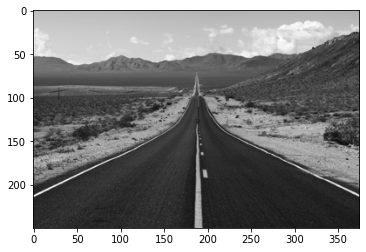

In [6]:
plt.imshow(im, cmap='gray', vmin=0, vmax=1);

In [7]:
# параметры двух фильтров

a1 = np.array(
    [[ 0,  1,  1, -1, -1],
     [ 0,  2,  0,  1, -2],
     [ 2,  1, -2, -1,  1],
     [ 0, -2, -1,  1,  0],
     [-1,  1,  0, -1,  2]]
).astype(np.float64)

a2 = np.array(
    [[ 2,  0,  1, -1,  0],
     [ 2, -2,  1,  0, -1],
     [ 2,  0, -1, -1,  0],
     [ 1, -1,  2, -1,  0],
     [ 0,  2,  1, -2, -1]]
).astype(np.float64)


In [9]:
imf1 = im.copy()
imf2 = im.copy()

for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        
        for k in range(-2, 3):
            if i + k < 0 or i + k >= im.shape[0]:
                continue
            for l in range(-2, 3):
                if j + l < 0 or j + l >= im.shape[1]:
                    continue
                imf1[i][j] += a1[k, l] * im[i + k, j + l]
                imf2[i][j] += a2[k, l] * im[i + k, j + l]


Text(0.5, 1.0, 'filter_2')

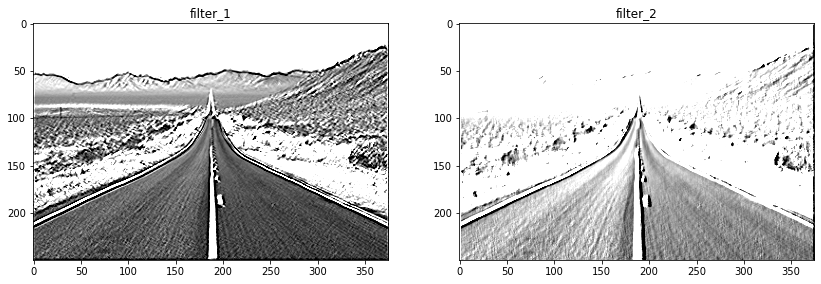

In [10]:
plt.figure(figsize=(14, 5))
plt.subplot("121")
plt.imshow(imf1, cmap='gray', vmin=0, vmax=1);
plt.title('filter_1')
plt.subplot("122")
plt.imshow(imf2, cmap='gray', vmin=0, vmax=1);
plt.title('filter_2')

## 2. Реализация через cuda

In [11]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [15]:
# копирование исходного изображения
im_gpu = cuda.mem_alloc(im.reshape(-1).nbytes)
cuda.memcpy_htod(im_gpu, im.reshape(-1))
# отфильтрованное изображение
imf1_gpu = cuda.mem_alloc(im.reshape(-1).nbytes)
cuda.memcpy_htod(imf1_gpu, im.reshape(-1))
imf2_gpu = cuda.mem_alloc(im.reshape(-1).nbytes)
cuda.memcpy_htod(imf2_gpu, im.reshape(-1))
# копирование фильтра
a1_gpu = cuda.mem_alloc(a1.reshape(-1).nbytes)
cuda.memcpy_htod(a1_gpu, a1.reshape(-1))
a2_gpu = cuda.mem_alloc(a2.reshape(-1).nbytes)
cuda.memcpy_htod(a2_gpu, a2.reshape(-1))
# копирование ширины и высоты картинки
w_gpu = cuda.mem_alloc(np.array(im.shape[1]).nbytes)
cuda.memcpy_htod(w_gpu, np.array(im.shape[1]))
h_gpu = cuda.mem_alloc(np.array(im.shape[0]).nbytes)
cuda.memcpy_htod(h_gpu, np.array(im.shape[0]))

In [17]:
mod = SourceModule("""

  __device__ unsigned int getGlobalIdx()
  {
      // глобальный индекс 
      unsigned int innerIdx = threadIdx.x + threadIdx.y * blockDim.x + threadIdx.z * blockDim.x * blockDim.y;
      unsigned int globalIdx = (blockIdx.x + blockIdx.y * gridDim.x + blockIdx.z * gridDim.x * gridDim.y) 
                              * blockDim.x * blockDim.y * blockDim.z 
                              + innerIdx;

      return globalIdx;
  }

  __global__ void Filter(double * im, double * imf, double * a, int * w, int * h)
  {
    unsigned int globalIdx = getGlobalIdx();

    int k, l, i, j;

    j = -1;
    for (k = -2; k < 3; k++)
    {
      for (l = -2; l < 3; l++)
      {
        j++;
        i = globalIdx + k * w[0] + l;
        if (i < 0 || i >= h[0] * w[0]) {
          continue;
        }
        imf[globalIdx] += a[j] * im[i];
      }
    }
  }

  """
)

In [18]:
func = mod.get_function("Filter")

# 1-ый фильтр
func(
    im_gpu, imf1_gpu, a1_gpu, w_gpu, h_gpu,
    block=(32, 32, 1), grid=(32, 32)
)

# 2-ой фильтр
func(
    im_gpu, imf2_gpu, a2_gpu, w_gpu, h_gpu,
    block=(32, 32, 1), grid=(32, 32)
)

In [20]:
# копирование на ЦПУ
imf1_cpu = np.empty_like(im.reshape(-1))
cuda.memcpy_dtoh(imf1_cpu, imf1_gpu)
imf1_cpu = imf1_cpu.reshape(im.shape)

imf2_cpu = np.empty_like(im.reshape(-1))
cuda.memcpy_dtoh(imf2_cpu, imf2_gpu)
imf2_cpu = imf2_cpu.reshape(im.shape)


Text(0.5, 1.0, 'filter_2')

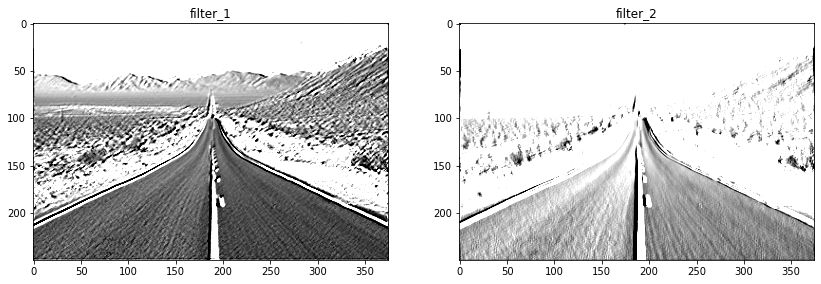

In [21]:
plt.figure(figsize=(14, 5))
plt.subplot("121")
plt.imshow(imf1_cpu, cmap='gray', vmin=0, vmax=1);
plt.title('filter_1')
plt.subplot("122")
plt.imshow(imf2_cpu, cmap='gray', vmin=0, vmax=1);
plt.title('filter_2')

Похоже!